In [1]:

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    ShuffleSplit,
    learning_curve
)
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    classification_report
)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet(r"../data/types_fixed_german_credit_data.parquet", engine="pyarrow")

Based on the heuristics proposed in the EDA only 4 columns are needed: **Credit amount, Purpose, Saving accounts and Housing**.

In [3]:
selected_features = ["Risk", "Credit amount", "Purpose", "Saving accounts", "Housing"]

df = df.drop_duplicates(subset=["Unnamed: 0"])

df = df[selected_features]
df = df.dropna(subset=["Risk"])  # Got to drop all rows where Risk is NAN. To stratify latter target var can not have missing values.
df["Risk"] = df["Risk"].map({"good": 1, "bad": 0}).astype("int8")

**Feature Engineering**

In [4]:
num_cols = ["Credit amount"]
cat_cols = ["Purpose", "Housing"]
cat_ord_cols = ["Saving accounts"]

In [5]:
def get_features_names(_, feature_names) -> np.ndarray:
    return feature_names

def clean_features(X: pd.DataFrame, values: dict[str] = None, expected: bool = True):
    assert isinstance(X, pd.DataFrame)
    assert isinstance(values, dict) or values is None 
    
    values = {
        "Housing": ["own", "rent", "free"],
        "Sex" : ["male", "female"],
        "Purpose" : [
            "car", 
            "radio/TV", 
            "furniture/equipment", 
            "business",
            "education",
            "repairs",
            "domestic appliances",
            "vacation/others"
        ]
    } if not values and expected else values
    
    categories_to_review: list[str] = list(set(X.columns).intersection(set(values.keys())))
    if len(categories_to_review) == 0: return X
    
    X[categories_to_review] = X[categories_to_review].apply(
        lambda x: x.where(x.isin(values[x.name]))
    ) if expected else X[categories_to_review].apply(
        lambda x: x.where(~x.isin(values[x.name]))
    )
    return X
    
    
def remove_outliers(X: pd.DataFrame, threshold: float = 1.5) -> pd.DataFrame:
    """
    Replace outliers from numeric columns given a certain treshold with NAN.
    Args:
        threshold (float, optional): Treshold for removing minor (1.5) or extreme outliers (3.0). Defaults to 1.5.
    """
    assert isinstance(X, pd.DataFrame)
    assert 1.5 <= threshold <= 3.0
    Q1, Q3 = X.quantile(0.25), X.quantile(0.75)
    IQR: float = Q3 - Q1
    mask: function = ~((X >= (Q1 - threshold * IQR)) & (X <= (Q3 + threshold * IQR))).all(axis=1)
    X.loc[mask] = np.nan
    return X

In [6]:
numeric_pipe = Pipeline(
    steps=[
        ("outlier removal", FunctionTransformer(
            remove_outliers,
            kw_args={'threshold': 3.0}, 
            feature_names_out=get_features_names
        )),
        ("imputer", KNNImputer(n_neighbors=5))
    ]
)

cat_pipe = Pipeline(
    steps=[
        ("clean_categories", FunctionTransformer(
            clean_features, 
            feature_names_out=get_features_names
        )),
        #("imputer", SimpleImputer(strategy="most_frequent")),
    ]
)

cat_ord_pipe = Pipeline(
    steps=[
        ("clean_categories", FunctionTransformer(
            clean_features, 
            feature_names_out=get_features_names
        )),
        #("imputer", SimpleImputer(strategy="most_frequent")),
    ]
)

ordinal_transformers = [(f"{col}_ordinal", cat_ord_pipe, [col]) for col in cat_ord_cols]


preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipe, num_cols),
        ("categoric", cat_pipe, cat_cols),
    ] + ordinal_transformers
)

In [7]:
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('outlier removal',
                                                  FunctionTransformer(feature_names_out=<function get_features_names at 0x0000015D833DDEE0>,
                                                                      func=<function remove_outliers at 0x0000015D833DDDA0>,
                                                                      kw_args={'threshold': 3.0})),
                                                 ('imputer', KNNImputer())]),
                                 ['Credit amount']),
                                ('categoric',
                                 Pipeline(steps=[('clean_categories',
                                                  FunctionTrans...<function get_features_names at 0x0000015D833DDEE0>,
                                                                      func=<function clean_features at 0x0000015D833DDE40>))]),
                                 ['Purpose', 'Housing']),
                                ('Saving accounts_ordinal',
                                 Pipeline(steps=[('clean_categories',
                                                  FunctionTransformer(feature_names_out=<function get_features_names at 0x0000015D833DDEE0>,
                                                                      func=<function clean_features at 0x0000015D833DDE40>))]),
                                 ['Saving accounts'])])

In [8]:
X_features = df.drop(columns=["Risk"])
Y_target = df["Risk"]

x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, stratify= Y_target
)

Let's check that the pipeline is droping weird categories

In [9]:
x_train[(x_train["Housing"].isin(["356", "43", "563"])) | (x_train["Purpose"].isin(["3", "356", "56", "6"]))]

,Credit amount,Purpose,Saving accounts,Housing
947,2108,radio/TV,little,43
248,10961,6,rich,own


In [10]:
cleaned: pd.DataFrame = pd.DataFrame(
    data = preprocessor.fit_transform(x_train),
    columns= preprocessor.get_feature_names_out()
)

cleaned[(cleaned["categoric__Housing"].isin(["356", "43", "563"])) | (cleaned["categoric__Purpose"].isin(["3", "356", "56", "6"]))]

,numeric__Credit amount,categoric__Purpose,categoric__Housing,Saving accounts_ordinal__Saving accounts


**Heuristic based model**

In [11]:
class HeuristicModel(BaseEstimator, ClassifierMixin):
    def fit(self, _, y=None):
        if y is not None:
            self.classes_ = np.unique(y)
        return self
    
    def predict(self, X) -> np.ndarray:
        assert all(len(input) == 4 for input in X), "Not all inputs have length 4"
        
        HOUSING = "own",  # x[0]
        CREDIT_AMOUNT_THRESHOLD_HIGH = 3900  # x[1]
        PURPOSE_1, PURPOSE_2 = "radio/TV", "car"  #x[2]
        SAVING_ACCOUNTS = "little"  # x[3]
        asses_risk = lambda x: 1 if (x[0] == HOUSING and x[1] <= CREDIT_AMOUNT_THRESHOLD_HIGH) or (x[2] == PURPOSE_1 or x[2] == PURPOSE_2) or (x[3] != SAVING_ACCOUNTS) else 0
        predictions = [asses_risk(input) for input in X]
        return np.array(predictions)

accuracy - CV mean: 0.532, CV std: 0.044986564641072695
accuracy - Train score: 0.5320855614973262
f1 - CV mean: 0.5780936788820407, CV std: 0.05642356045321816
f1 - Train score: 0.5320855614973262
precision - CV mean: 0.7787666806936584, CV std: 0.041857948390134014
precision - Train score: 0.5320855614973262
recall - CV mean: 0.46259071117561684, CV std: 0.06502819798920374
recall - Train score: 0.5320855614973262


<Axes: title={'center': 'Cross Validation Boxplot'}, ylabel='Score'>

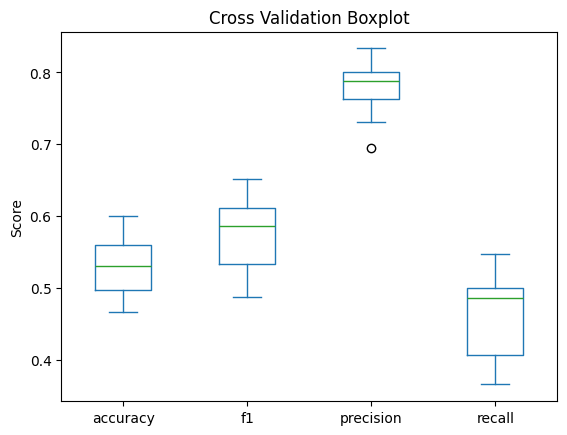

In [12]:
model = HeuristicModel()
scoring_metrics = ["accuracy", "f1", "precision", "recall"]
fold = StratifiedKFold(n_splits=10)  # better for classification, mantains classes proportion in each fold
model_pipe = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("undersampling", RandomUnderSampler(random_state=42)),
    ("model", model)
])
cv_results = {}
train_results = {}

for metric in scoring_metrics:
    cv_results[metric] = cross_val_score(
        model_pipe, x_train, y_train, cv=fold, scoring=metric
    )
    # Evaluate on the training set
    model_pipe.fit(x_train, y_train)
    train_results[metric] = model_pipe.score(x_train, y_train)

# Convert results into a pandas DataFrame
cv_results_df = pd.DataFrame(cv_results)

for metric_name in scoring_metrics:
    print(
        f"{metric_name} - CV mean: {cv_results_df[metric_name].mean()}, "
        f"CV std: {cv_results_df[metric_name].std()}"
    )
    print(f"{metric_name} - Train score: {train_results[metric_name]}")

# Create a boxplot for the cross-validation results of each metric
cv_results_df.plot.box(title="Cross Validation Boxplot", ylabel="Score")

<Axes: title={'center': 'Training vs Cross-Validation Scores'}, xlabel='Metric', ylabel='Score'>

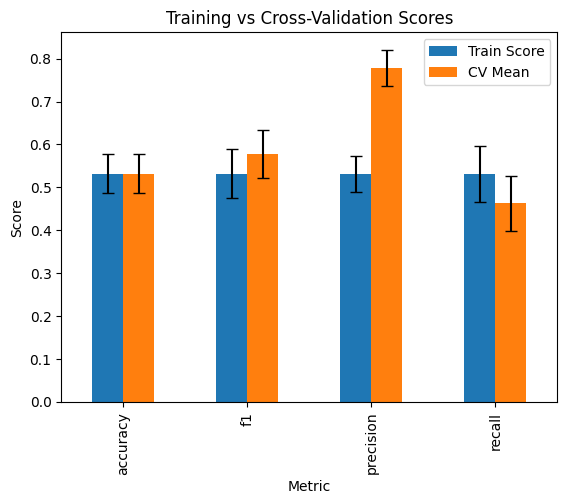

In [13]:
metrics_df = pd.DataFrame(
    {
        "Metric": scoring_metrics,
        "Train Score": [train_results[metric] for metric in scoring_metrics],
        "CV Mean": [cv_results_df[metric].mean() for metric in scoring_metrics],
        "CV Std": [cv_results_df[metric].std() for metric in scoring_metrics],
    }
)

# Create a bar plot for the training and cross-validation metrics
metrics_df.plot(
    kind="bar",
    x="Metric",
    y=["Train Score", "CV Mean"],
    yerr="CV Std",
    title="Training vs Cross-Validation Scores",
    ylabel="Score",
    capsize=4,
)

**Analysis of the results of all metrics**

Each metric's mean CV score tells how well the model performs on unseen data, while the standard deviation shows variability across folds.

The train score indicates how well the model fits the training data.

1. Accuracy
   - Interpretation: The accuracy on the training set is very close to the cross-validation mean accuracy. The standard deviation indicates moderate variability in accuracy across different folds.
2. F1 score
   - Interpretation: The F1 score is lower on the training set than the cross-validation mean F1 score. The standard deviation indicates moderate variability in F1 score across different folds.
3. Precision
   - Interpretation: The precision is much lower on the training set than the cross-validation mean precision score. The standard deviation indicates moderate variability in precision score across different folds.
4. Recall
   - Interpretation: The recall score on the training set is significantly higher than the cross-validation mean recall score. The standard deviation indicates moderate variability in recall score across different folds.

The higher precision on cross-validation than on training data could occur if the distribution of labels changes across folds, where some validation sets contain easier-to-classify samples, leading to higher precision, while the training set has a more challenging distribution, resulting in lower precision.

**Final evaluation**

In [14]:
y_pred = model_pipe.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.36      0.72      0.48        57
           1       0.79      0.45      0.57       131

    accuracy                           0.53       188
   macro avg       0.57      0.58      0.53       188
weighted avg       0.66      0.53      0.55       188



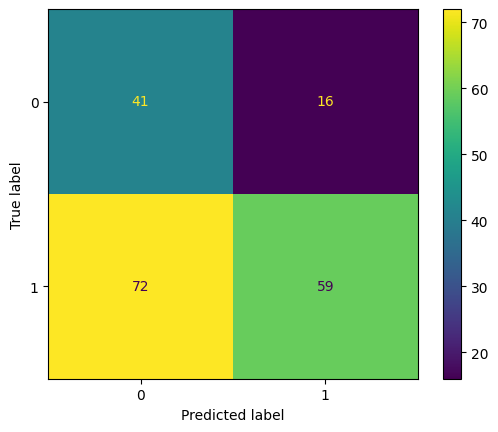

In [15]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

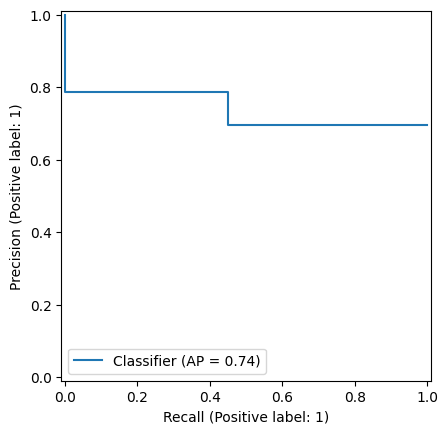

In [16]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred)

- Curve has an abrupt drop down, which means the model loses precision when recall augmentates.

**Only one metric (Precision)**
Precision is the chosen metric for this credit risk model because it is more important to ensure that approved credits are truly good, minimizing the risk of granting loans to bad creditors.

The objective of this model is to correctly identify good credit applicants while avoiding false approvals of bad credits. Hypothetically, the model is going to be used to approve loans with minimal risk, so precision is the most important metric for this model.

Precision is crucial because it measures the model’s ability to correctly classify applicants as good credit risks. In situations where the cost of approving a bad credit (False Positive, FP) is high—leading to financial losses and increased default rates—it is more important to ensure that approved loans are truly reliable, even if it means rejecting some potentially good applicants.

The False Positive (FP) is the most critical error in this case, as approving a bad credit applicant can result in financial losses. By prioritizing precision, the model ensures that only the most trustworthy applicants are approved, reducing the risk of defaults and improving overall loan portfolio quality.

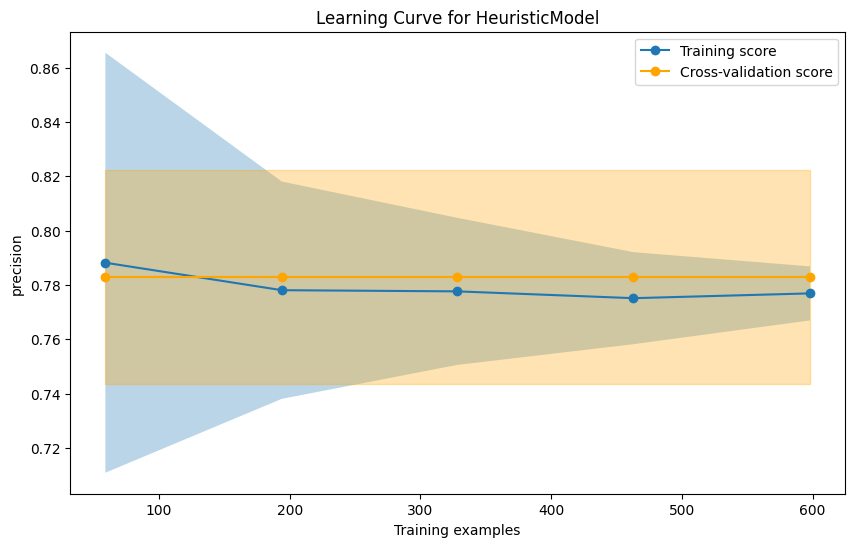

Training Sizes: [ 59 194 328 463 598]
Training Scores Mean: [0.78817751 0.77807076 0.77764119 0.77513267 0.7768911 ]
Training Scores Std: [0.07727373 0.03997574 0.02707333 0.01693112 0.00994221]
Test Scores Mean: [0.78285912 0.78285912 0.78285912 0.78285912 0.78285912]
Test Scores Std: [0.03943226 0.03943226 0.03943226 0.03943226 0.03943226]


In [17]:
# Define pipeline = preprocessor + model
model = HeuristicModel()
model_pipe = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("undersampling", RandomUnderSampler(random_state=42)),
    ("model", model)
])

# Parameters for the learning curve
common_params = {
    "X": x_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=123),
    "n_jobs": -1,
    "return_times": True,
}

scoring_metric = "precision"

# Obtain the learning curve values including fit and score times
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    model_pipe, **common_params, scoring=scoring_metric
)

# Calculate the mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Calculate the mean and standard deviation of the fit and score times
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)
score_times_mean = np.mean(score_times, axis=1)
score_times_std = np.std(score_times, axis=1)

# Plot the learning curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)
ax.plot(train_sizes, train_mean, "o-", label="Training score")
ax.plot(train_sizes, test_mean, "o-", color="orange", label="Cross-validation score")
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
ax.fill_between(
    train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3, color="orange"
)

# Configure the title and labels
ax.set_title(f"Learning Curve for {model.__class__.__name__}")
ax.set_xlabel("Training examples")
ax.set_ylabel(scoring_metric)
ax.legend(loc="best")

# Show the plot
plt.show()

# Print the values for analysis
print("Training Sizes:", train_sizes)
print("Training Scores Mean:", train_mean)
print("Training Scores Std:", train_std)
print("Test Scores Mean:", test_mean)
print("Test Scores Std:", test_std)

**Interpretation of the learning curve based on precision only**
1. Training Scores
   - Interpretation:
     - The training **precision** score slowly increases until reaching **0.7768911** as more data is added.
     - The standard deviation decreases as the training size increases, indicating that the model’s performance on the training set becomes more consistent with more data.
2. Test Scores
   - Interpretation:
     - The test precision score is stable at **0.78285912** across all training sizes.
     - The constant standard deviation suggests that the model’s performance on the test set is consistently stable across different folds of the cross-validation.

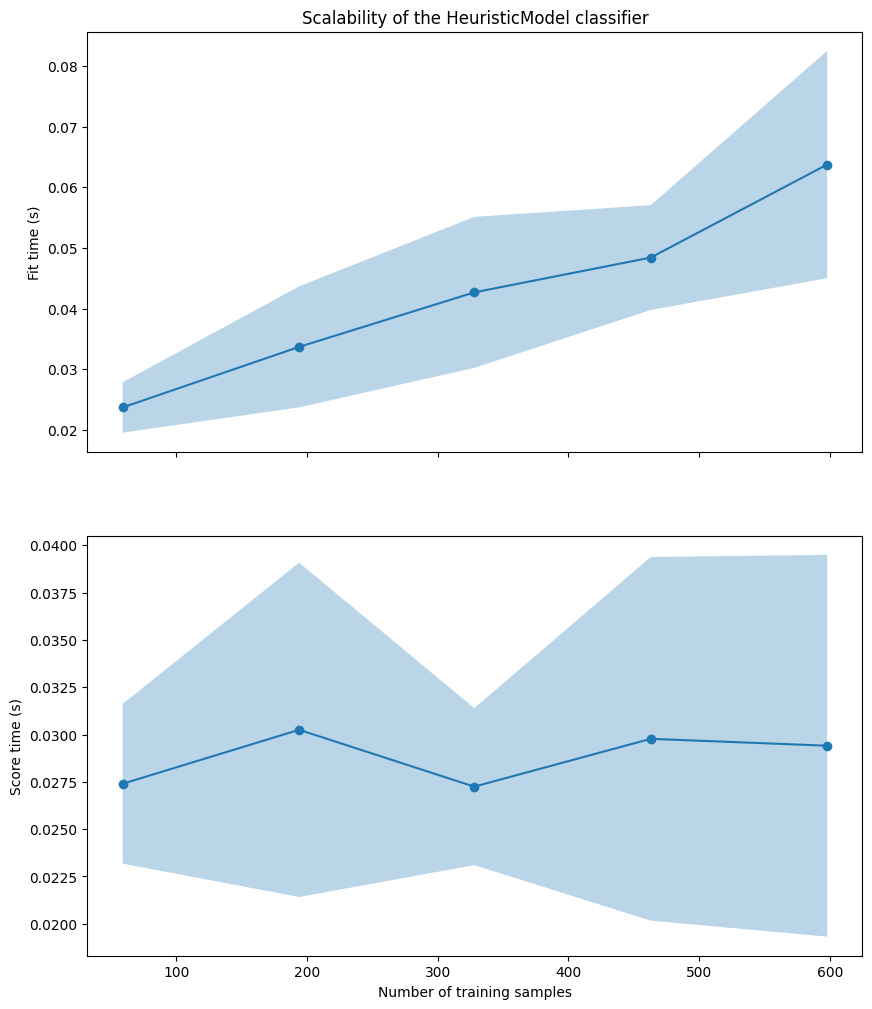

Fit Times Mean: [0.02372774 0.03369983 0.04268052 0.04841024 0.06374063]
Fit Times Std: [0.00415046 0.00996456 0.01244148 0.00863292 0.01872884]
Score Times Mean: [0.02739719 0.03025004 0.02724683 0.02977302 0.02940851]
Score Times Std: [0.0042191  0.00883565 0.0041482  0.00960697 0.01008774]


In [18]:
# Plot the scalability regarding fit time and score time
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

# Scalability regarding the fit time
ax[0].plot(train_sizes, fit_times_mean, "o-")
ax[0].fill_between(
    train_sizes,
    fit_times_mean - fit_times_std,
    fit_times_mean + fit_times_std,
    alpha=0.3,
)
ax[0].set_ylabel("Fit time (s)")
ax[0].set_title(f"Scalability of the {model.__class__.__name__} classifier")

# Scalability regarding the score time
ax[1].plot(train_sizes, score_times_mean, "o-")
ax[1].fill_between(
    train_sizes,
    score_times_mean - score_times_std,
    score_times_mean + score_times_std,
    alpha=0.3,
)
ax[1].set_ylabel("Score time (s)")
ax[1].set_xlabel("Number of training samples")

# Show the plot
plt.show()

# Print the fit and score times for analysis
print("Fit Times Mean:", fit_times_mean)
print("Fit Times Std:", fit_times_std)
print("Score Times Mean:", score_times_mean)
print("Score Times Std:", score_times_std)


**Interpretation of the fit and score times based on precision**
1. Fit times
   - Interpretation: 
     - The fit times are unstable, increasing at the same pace as the training size.
     - Standard deviation increases with the training size, indicating unconsistent fit times as the input increases.
2. Score times
   - Interpretation:
     - The score times are low and stable, with minimal variation as the training size increases.
     - The low standard deviation indicates consistent score times across different folds.

# General results
- Model performance
  - The training and test precision scores are stable, indicating that the model performs consistently well on both the training and test sets.
  - The minimal difference between the training and test scores suggests that the model generalizes well to unseen data and is not overfitting.
- Consistency
  - The standard deviation decrease as the training size increases, indicates that the model’s performance on the training set becomes more consistent with more data.
  - The constant standard deviation of the test scores indicates that the model’s performance on the test set is consistently stable across different folds.
- Scalability
  - The fit times exhibit an O(n) alike behaviour due to the KNN imputer, increasing the time taken as the training size increases as well. This could be due to a pipeline overhead. In either case an O(n) behaviour is nothing to worry about.
  - The score times are low and stable, indicating that the model is computationally efficient and scoring scales well with increasing training sizes.
## Recomendations
1. Continue with Current Model: Given the good generalization and stable performance, is factible to continue using the current model configuration.
2. Monitor Performance: Keep monitoring the model’s performance with new data to ensure it continues to generalize well.
## Proposals and ideas
1. Using More Complex Models:
   - Proposal: Experiment with more complex models such as Random Forests, Gradient Boosting Machines, like xgboost.
   - Rationale: More complex models can capture more intricate patterns in the data, potentially improving performance. However, they may also require more computational resources and careful tuning to avoid overfitting.
2. Using More Columns (Features):
   - Proposal: Incorporate additional features into the model, more columns from the original dataset in order to improve the model’s predictive power.
   - Rationale: More features can provide the model with more information, potentially improving its ability to make accurate predictions. Feature selection techniques can be used to identify the most relevant features and avoid overfitting
3. Hyperparameter Tuning:
   - Proposal: Use techniques such as Grid Search or Random Search to find the optimal hyperparameters for the model.
   - Rationale: Proper hyperparameter tuning can significantly improve the model’s performance by finding the best settings for the learning algorithm.